# Custom Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2023-12-09 17:43:33.379867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Custom Model, Training Loops

### Model

In [2]:
class SimpleModel:
    def __init__(self):
        self.w = tf.Variable(3, dtype=tf.float32)
        self.b = tf.Variable(0, dtype=tf.float32)
    
    def __call__(self, x):
        return self.w * x + self.b

model = SimpleModel()

### Loss

In [3]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

### Synthesize training data

In [4]:
TRUE_W = 3.0
TRUE_B = 2.0
NUM_SAMPLES = 1000

xs = tf.random.normal(shape=[NUM_SAMPLES], dtype=tf.float32)
ys = (TRUE_W * xs) + TRUE_B

### Plot True vs Predicted

In [5]:
def plot_data(x, y_true, y_pred):
    
    true_plt = plt.scatter(x, y_true, c='b')
    pred_plt = plt.scatter(x, y_pred, c='r')

    plt.legend((true_plt, pred_plt), ('True', 'Prediction'))
    plt.show()

### Train

In [6]:
def train(model: SimpleModel, x, y, lr):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        curr_loss = mse_loss(y, y_pred)
    
    dw, db = tape.gradient(curr_loss, [model.w, model.b])

    model.w.assign_sub(lr*dw)
    model.b.assign_sub(lr*db)

    return curr_loss

### Training

In [7]:
model = SimpleModel()

for epoch in range(5):
    loss = train(model, xs, ys, 0.1)
    print(f'Weight {model.w.numpy()} - Bias {model.b.numpy()} - Loss {loss}')

Weight 2.9911062717437744 - Bias 0.40000006556510925 - Loss 4.0
Weight 2.9857728481292725 - Bias 0.7199605107307434 - Loss 2.559446334838867
Weight 2.9829306602478027 - Bias 0.975905179977417 - Loss 1.6378940343856812
Weight 2.9817960262298584 - Bias 1.1806482076644897 - Loss 1.048284649848938
Weight 2.9817991256713867 - Bias 1.344437599182129 - Loss 0.6710059642791748


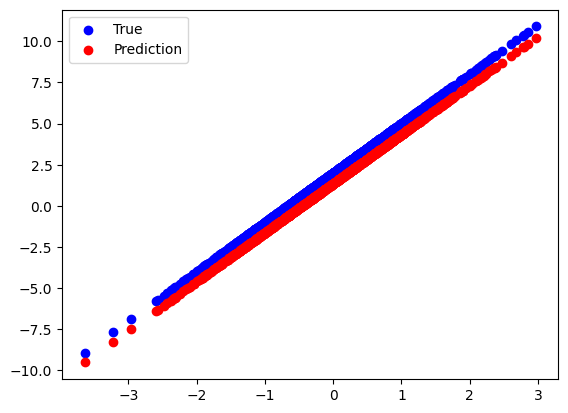

In [8]:
plot_data(xs, ys, model(xs))

## TensorFlow Datasets

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

### Load datasets

In [10]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/tensorflow_datasets', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/tensorflow_datasets', download=True)

In [11]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Preprocess Data

In [12]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='./data/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    

In [13]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [14]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [15]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test =  test_data.batch(batch_size=batch_size)

### Build Model

In [16]:
def base_model():
   inputs = tf.keras.Input(shape=(784,), name='digits')
   x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
   x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
   outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
   model = tf.keras.Model(inputs=inputs, outputs=outputs)
   return model

### Optimizer & Loss Function

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

### Metrics

In [18]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

### Building Training Loop

In [19]:
def apply_gradient(optimizer, model, x, y):
  
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

In [20]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

In [21]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

In [22]:

model = base_model()

# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.2212: 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.5416  Validation Loss: 0.4435, Train Accuracy: 0.8105, Validation Accuracy 0.8402
Start of epoch 1


Training loss for step 937: 0.4566: 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.3943  Validation Loss: 0.4157, Train Accuracy: 0.8576, Validation Accuracy 0.8501
Start of epoch 2


Training loss for step 937: 0.4251: 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.3566  Validation Loss: 0.3917, Train Accuracy: 0.8707, Validation Accuracy 0.8599
Start of epoch 3


Training loss for step 937: 0.2440: 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.3307  Validation Loss: 0.3891, Train Accuracy: 0.8791, Validation Accuracy 0.8622
Start of epoch 4


Training loss for step 937: 0.3280: 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.3143  Validation Loss: 0.3948, Train Accuracy: 0.8848, Validation Accuracy 0.8589


### Evaluate

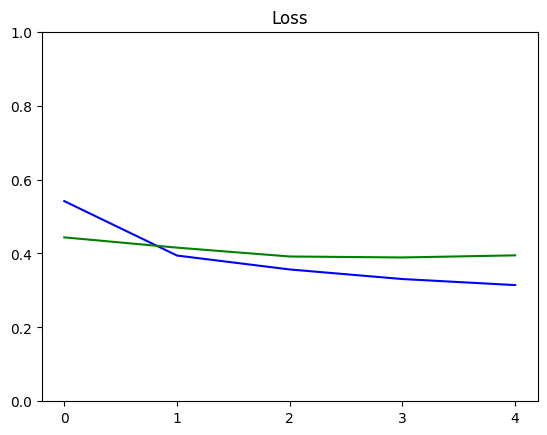

In [23]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [24]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

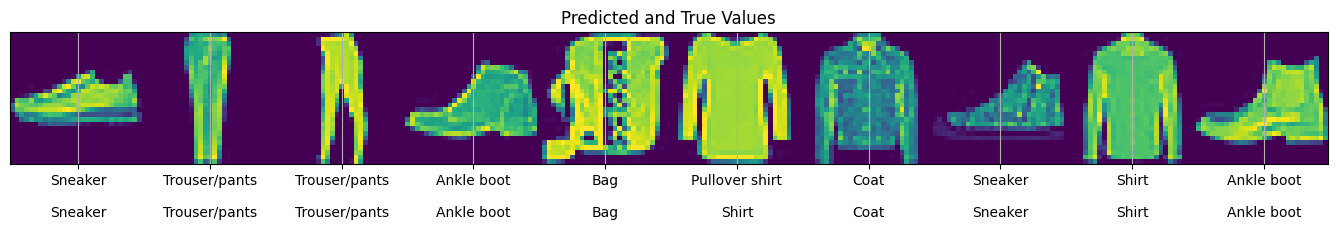

In [25]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)